In [1]:
!git clone https://github.com/Adnannewb/210150_CNN_Implementations.git
%cd 210150_CNN_Implementations


Cloning into '210150_CNN_Implementations'...
remote: Enumerating objects: 172, done.
remote: Counting objects: 100% (172/172), done.
remote: Compressing objects: 100% (171/171), done.
remote: Total 172 (delta 0), reused 172 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (172/172), 24.15 MiB | 41.42 MiB/s, done.
/content/210150_CNN_Implementations


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image
import os
from sklearn.metrics import confusion_matrix
import random
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [3]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])


In [4]:
train_dataset = datasets.ImageFolder(
    root="dataset/train",
    transform=transform
)

val_dataset = datasets.ImageFolder(
    root="dataset/val",
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)

class_names = train_dataset.classes
print("Classes:", class_names)


Classes: ['apple', 'banana', 'orange']


In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool  = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [16]:
epochs = 10
train_losses = []
train_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc  = 100 * correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{epochs}] Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%")


Epoch [1/10] Loss: 0.0473, Acc: 97.50%
Epoch [2/10] Loss: 0.0306, Acc: 99.17%
Epoch [3/10] Loss: 0.0268, Acc: 99.17%
Epoch [4/10] Loss: 0.0178, Acc: 99.17%
Epoch [5/10] Loss: 0.0129, Acc: 100.00%
Epoch [6/10] Loss: 0.0107, Acc: 100.00%
Epoch [7/10] Loss: 0.0079, Acc: 100.00%
Epoch [8/10] Loss: 0.0054, Acc: 100.00%
Epoch [9/10] Loss: 0.0039, Acc: 100.00%
Epoch [10/10] Loss: 0.0033, Acc: 100.00%


In [17]:
os.makedirs("model", exist_ok=True)
torch.save(model.state_dict(), "model/210150.pth")


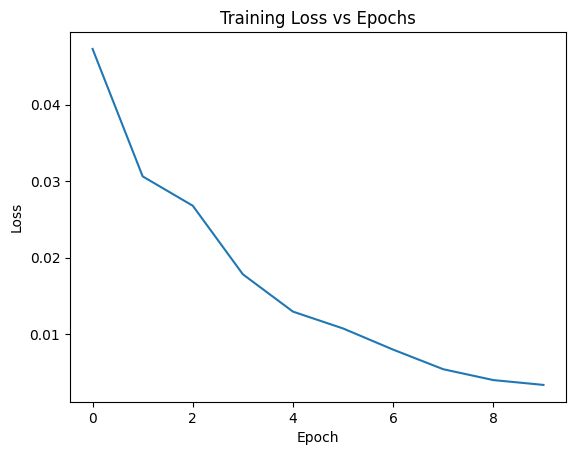

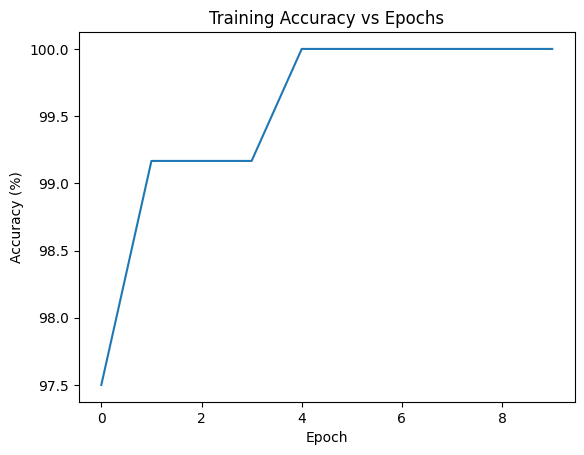

In [18]:
plt.figure()
plt.plot(train_losses)
plt.title("Training Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure()
plt.plot(train_accuracies)
plt.title("Training Accuracy vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.show()


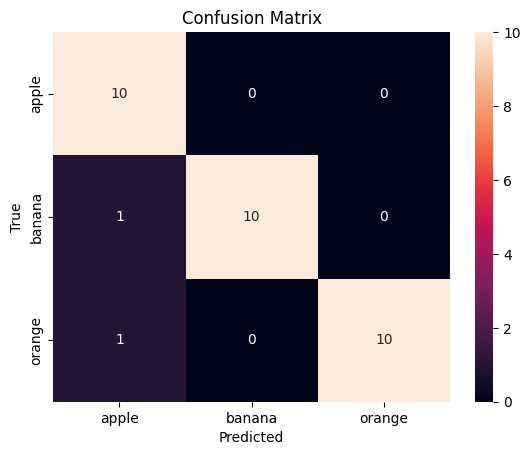

In [19]:
y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images.to(device))
        _, preds = outputs.max(1)

        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


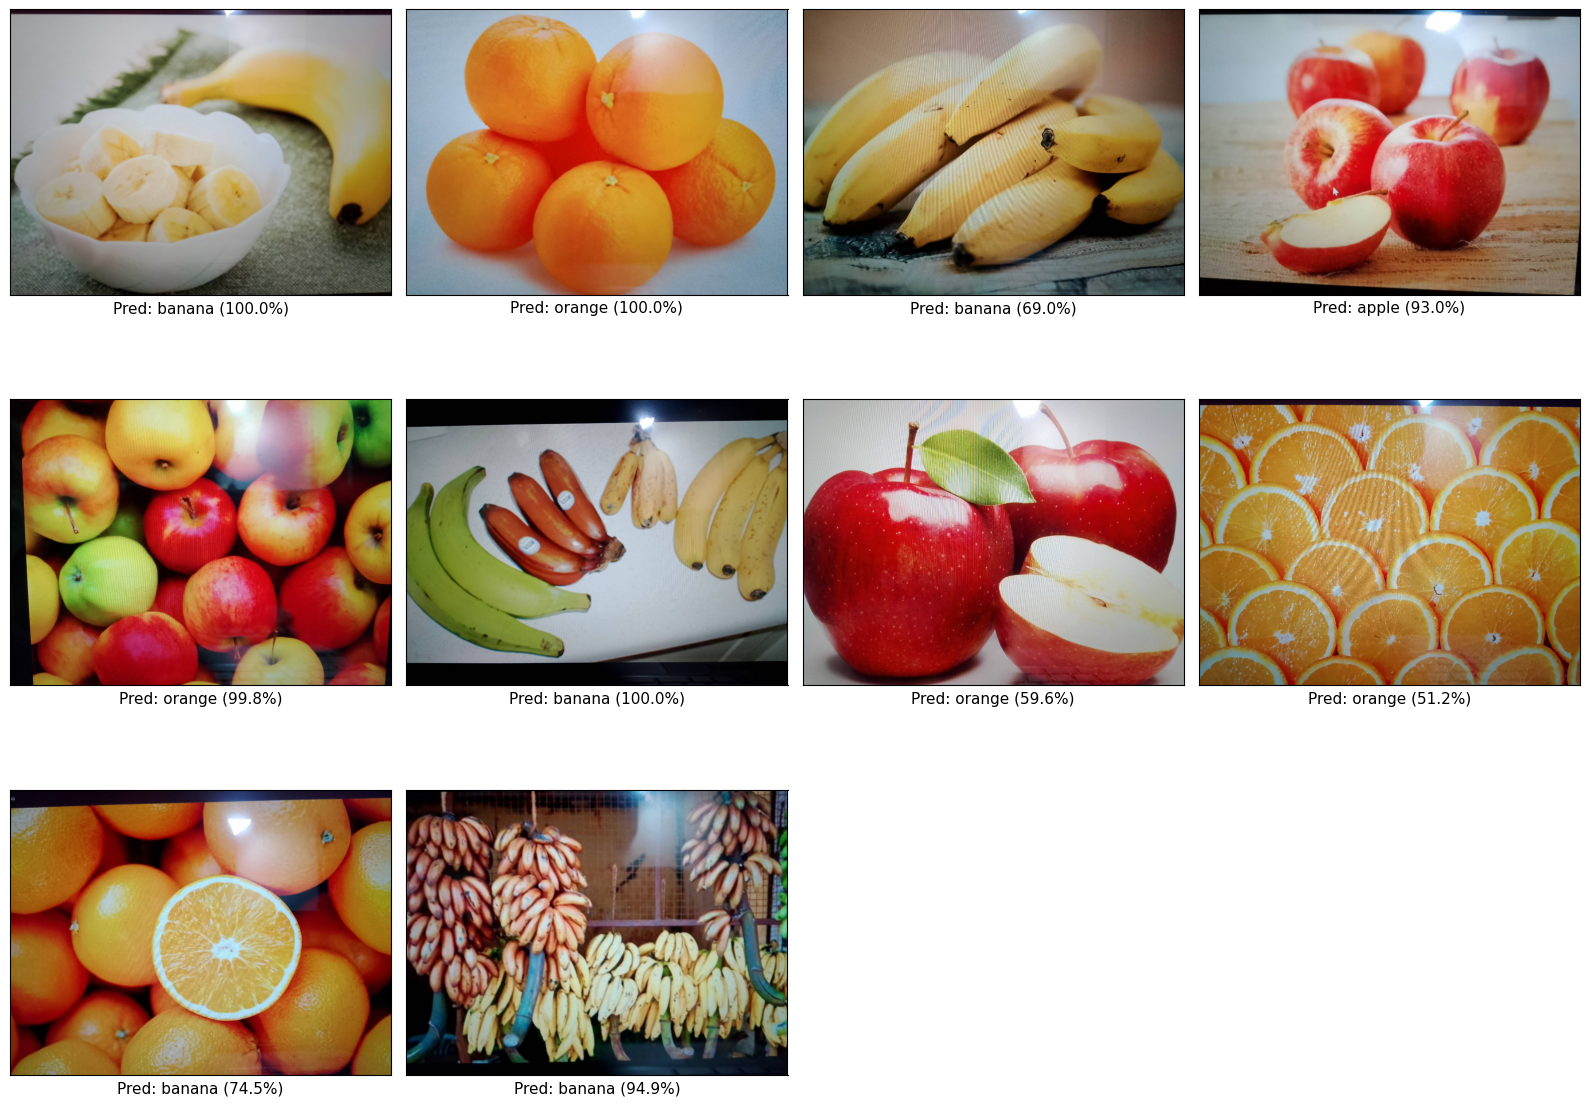

In [20]:
custom_dir = "dataset/custom"

model.eval()

images = os.listdir(custom_dir)
num_images = len(images)

cols = 4
rows = (num_images + cols - 1) // cols

plt.figure(figsize=(16, 4 * rows))

for i, img_name in enumerate(images):
    img = Image.open(os.path.join(custom_dir, img_name)).convert("RGB")
    img_t = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_t)
        probs = torch.softmax(output, dim=1)
        conf, pred = probs.max(1)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.xlabel(f"Pred: {class_names[pred]} ({conf.item()*100:.1f}%)",
               fontsize=11)
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()


Wrong predictions found: 3


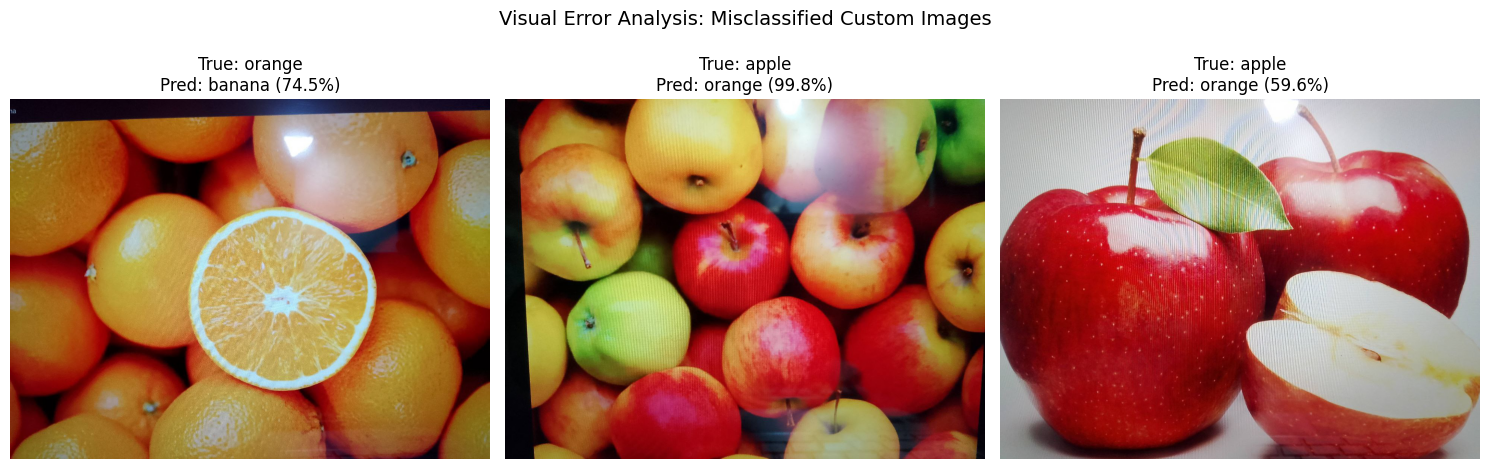

In [21]:
custom_dir = "dataset/custom"


def get_true_label(filename):
    for cls in class_names:
        if cls in filename.lower():
            return class_names.index(cls)
    return None


incorrect = []

model.eval()
images = os.listdir(custom_dir)

for img_name in images:
    img_path = os.path.join(custom_dir, img_name)
    img = Image.open(img_path).convert("RGB")
    img_t = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_t)
        probs = torch.softmax(output, dim=1)
        conf, pred = probs.max(1)

    true_label = get_true_label(img_name)
    if true_label is None:
        continue

    if pred.item() != true_label:
        incorrect.append((img, true_label, pred.item(), conf.item()))

num_wrong = len(incorrect)
print(f"Wrong predictions found: {num_wrong}")

if num_wrong == 0:
    print("No misclassified images found!")
else:

    sample_wrong = random.sample(incorrect, min(3, num_wrong))
    cols = len(sample_wrong)
    plt.figure(figsize=(5 * cols, 5))

    for i, (img, true_cls, pred_cls, conf) in enumerate(sample_wrong):
        plt.subplot(1, cols, i + 1)
        plt.imshow(img)
        plt.title(f"True: {class_names[true_cls]}\nPred: {class_names[pred_cls]} ({conf*100:.1f}%)",
                  fontsize=12)
        plt.axis("off")

    plt.suptitle("Visual Error Analysis: Misclassified Custom Images", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [22]:
# from google.colab import files
# files.download("model/210150.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>